Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmist.ipynb`.

In [23]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (300000, 28, 28), (300000,))
('Validation set', (60000, 28, 28), (60000,))
('Test set', (18724, 28, 28), (18724,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [24]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (300000, 784), (300000, 10))
('Validation set', (60000, 784), (60000, 10))
('Test set', (18724, 784), (18724, 10))


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 19.431513
Training accuracy: 6.6%
Validation accuracy: 10.3%
Loss at step 100: 2.436723
Training accuracy: 70.9%
Validation accuracy: 70.2%
Loss at step 200: 1.942931
Training accuracy: 73.9%
Validation accuracy: 72.8%
Loss at step 300: 1.682984
Training accuracy: 75.2%
Validation accuracy: 73.8%
Loss at step 400: 1.511981
Training accuracy: 76.0%
Validation accuracy: 74.2%
Loss at step 500: 1.387057
Training accuracy: 76.6%
Validation accuracy: 74.5%
Loss at step 600: 1.289858
Training accuracy: 77.2%
Validation accuracy: 74.7%
Loss at step 700: 1.210702
Training accuracy: 77.8%
Validation accuracy: 74.9%
Loss at step 800: 1.144348
Training accuracy: 78.2%
Validation accuracy: 75.1%
Test accuracy: 82.5%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.545992
Minibatch accuracy: 3.9%
Validation accuracy: 7.4%
Minibatch loss at step 500: 1.644372
Minibatch accuracy: 77.3%
Validation accuracy: 75.7%
Minibatch loss at step 1000: 1.516829
Minibatch accuracy: 76.6%
Validation accuracy: 76.5%
Minibatch loss at step 1500: 1.501507
Minibatch accuracy: 80.5%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 0.905604
Minibatch accuracy: 83.6%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 1.338037
Minibatch accuracy: 73.4%
Validation accuracy: 78.2%
Minibatch loss at step 3000: 1.062147
Minibatch accuracy: 82.0%
Validation accuracy: 78.5%
Test accuracy: 86.0%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [38]:
batch_size = 512
hidden_nodes = 2048

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  #tf_valid_dataset = tf.constant(valid_dataset)
  #tf_test_dataset = tf.constant(test_dataset)
  
  # input layer variables
  weights_i = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_i = tf.Variable(tf.zeros([hidden_nodes]))
  #input operation
  #logits = tf.matmul(tf_train_dataset, weights_i) + biases_i
    
  # hidden layer variables
  #W_fc1 = tf.Variable(tf.truncated_normal([1024, num_labels]))
  #b_fc1 = tf.Variable(tf.zeros([num_labels]))

  #h_pool2_flat = tf.reshape(weights_i, [-1, 7*7*64])
  #h_fc1 = tf.nn.relu(tf.matmul(logits, W_fc1) + b_fc1)
  h_fc1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_i) + biases_i)

  # output layer variables
  weights_o = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
  biases_o = tf.Variable(tf.zeros([num_labels]))
  #output operation
  logits_o = tf.matmul(h_fc1, weights_o) + biases_o
  y_conv = tf.nn.softmax(logits_o)  
  #define loss
  #loss = tf.reduce_mean(cross_entropy)  
  #loss = -tf.reduce_sum(tf_train_labels*tf.log(y_conv))
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels))
  # Optimizer.
  #optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  #decay learning rate
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    0.1, global_step * batch_size, train_dataset.shape[0] / 2, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  #train_prediction = tf.nn.softmax(logits_o)
  #valid_prediction = tf.nn.softmax(
  #  tf.matmul(tf_valid_dataset, weights_i) + biases_i)
  #test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights_o) + biases_o)  
  is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
  accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
  #tf.nn.softmax(tf.matmul(tf_test_dataset, weights_o) + biases_o)
  saver = tf.train.Saver(max_to_keep=20)

In [39]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, lr = session.run(
      [optimizer, loss, learning_rate], feed_dict=feed_dict)
    if (step % 200 == 0):
      print("Minibatch loss at step %d: %f with learning rate %f" % (step, l, lr))
      train_accuracy = accuracy_l.eval(feed_dict={tf_train_dataset:batch_data, tf_train_labels: batch_labels})
      print "step %d, training accuracy %g" % (step, train_accuracy)
      print("Validation accuracy: %g" % 
            accuracy_l.eval(feed_dict={ tf_train_dataset: valid_dataset, tf_train_labels: valid_labels}))
      #save model
      saver.save(session, './model.ckpt', global_step=step)
    
  print("test accuracy %g" % accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels}))
  #print("Test accuracy: %.1f%%" % accuracy_l.eval(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 495.862335 with learning rate 0.100000
step 0, training accuracy 0.335938
Validation accuracy: 0.277633
Minibatch loss at step 200: 31.228142 with learning rate 0.100000
step 200, training accuracy 0.828125
Validation accuracy: 0.78495
Minibatch loss at step 400: 33.188515 with learning rate 0.095000
step 400, training accuracy 0.841797
Validation accuracy: 0.7955
Minibatch loss at step 600: 24.497917 with learning rate 0.090250
step 600, training accuracy 0.849609
Validation accuracy: 0.826083
Minibatch loss at step 800: 20.878269 with learning rate 0.090250
step 800, training accuracy 0.853516
Validation accuracy: 0.830217
Minibatch loss at step 1000: 19.089355 with learning rate 0.085737
step 1000, training accuracy 0.871094
Validation accuracy: 0.835483
Minibatch loss at step 1200: 17.598488 with learning rate 0.081451
step 1200, training accuracy 0.878906
Validation accuracy: 0.836467
Minibatch loss at step 1400: 16.535933 with learning rate 0

test accuracy 0.921598


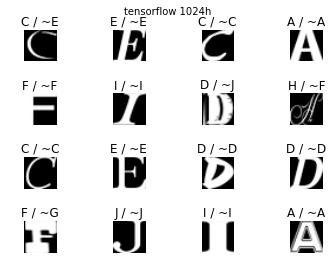

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import random

def predict_letter(image, model):
    with model.as_default():
        probs = y_conv.eval(feed_dict={ tf_train_dataset: image, tf_train_labels: [[0,0,0,0,0,0,0,0,0,0]]})
    #print probs
    return tf.argmax(probs,1).eval() #return index of max value
    

def display_sample(dataset, labels, title_label, model=None):    
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()    
    fig.suptitle(title_label)    
    for d in range(0, 16):
        a=fig.add_subplot(gs[d])
        letter_idx = int(len(dataset)*random.random())
        #print(letter_idx)
        plt.imshow(dataset[letter_idx].reshape((28,28)), cmap = cm.Greys_r)
        l_title = chr(tf.argmax(labels[letter_idx],0).eval() + ord('A'))
        if model is not None:
            letter_class = predict_letter(dataset[letter_idx].reshape(1, -1), model)
            #print letter_class
            l_title = l_title + ' / ~' + chr(letter_class + ord('A'))
        a.set_title(l_title)
        a.axis('off')    
    plt.show()
    
with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())
    #load model
    ckpt = tf.train.get_checkpoint_state('./')
    #print ckpt
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    print("test accuracy %g" % 
          accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels}))
    display_sample(test_dataset, test_labels, "tensorflow 1024h", sess)
